In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import uniform, randint, expon, beta
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor



## Read Data

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
y = df_train['SalePrice'].reset_index(drop=True)





In [212]:
print(df_train.shape)
print(df_test.shape)


(1460, 81)
(1459, 80)


In [213]:
df_train.info(verbose = False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


## Visulizing Null values 

In [214]:
def draw_missing_data(df):
    fx, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 13))

    df_na = df.isnull().mean().sort_values(ascending=True)  
    df_na_ = df_na[df_na > 0.]  

    # Show all the columns
    df_na.plot.barh(color='black', ax=axes[0])
    axes[0].axvline(x=0.1, color='r', linestyle='--')
    _ = axes[0].set_title('Missing Values Shares per Column', fontsize=20)

    # Zoom in
    df_na_.plot.barh(color='black', ax=axes[1], fontsize=20)
    axes[1].axvline(x=0.1, color='r', linestyle='--')
    _ = axes[1].set_title('Missing Values Shares per Column (Zoom in)', fontsize=20)

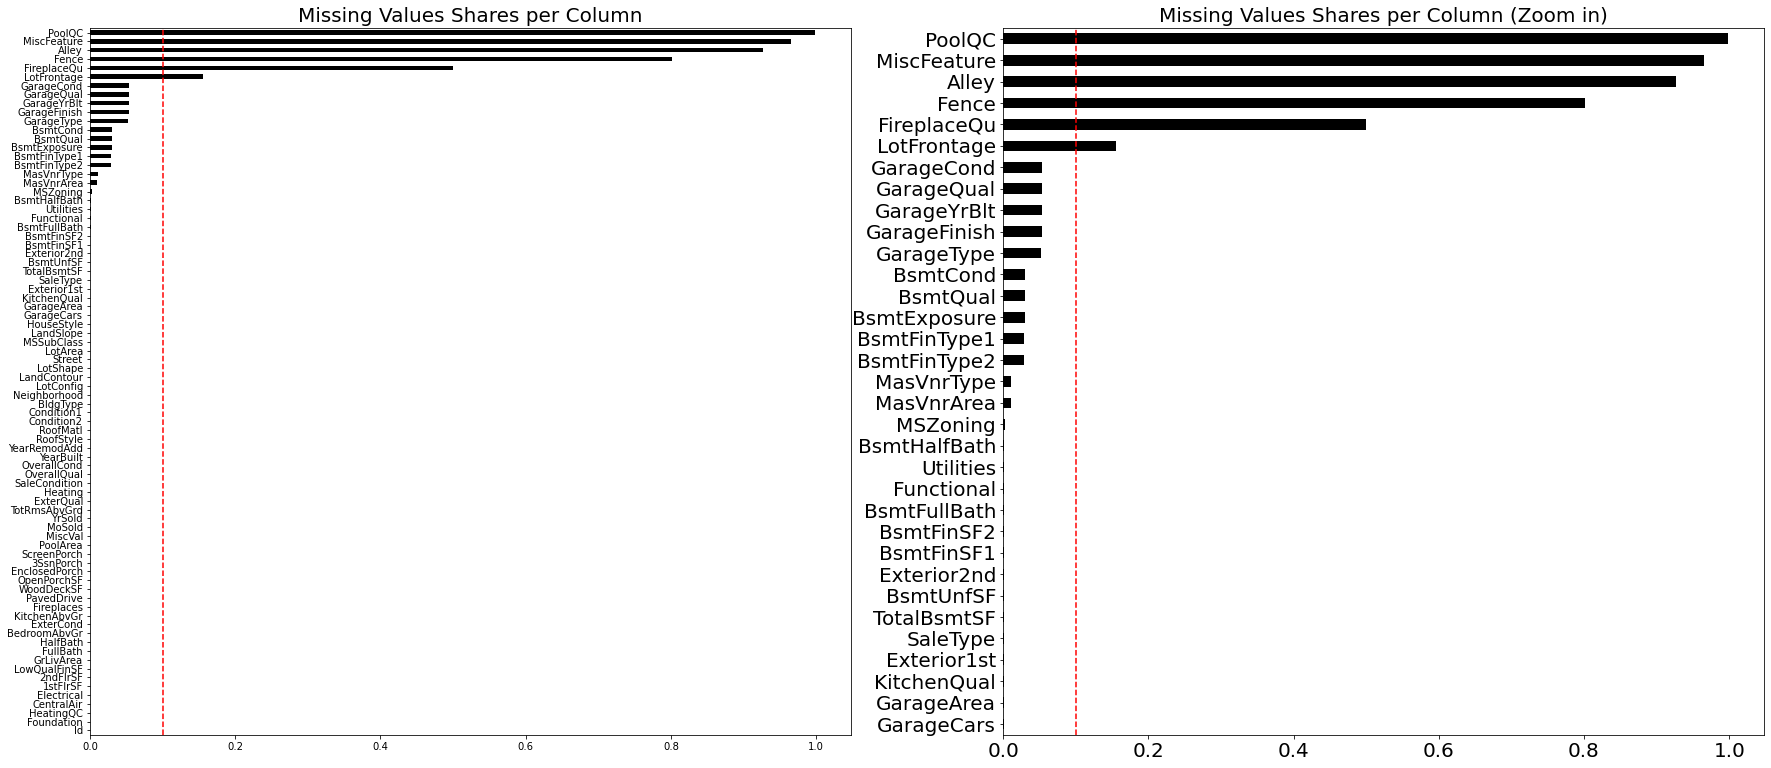

In [215]:
draw_missing_data(df_test)


In [216]:
na_drop_rt = 0.1  # Cols with missing rate above the threshold are dropped.

train_df_na = df_train.isnull().mean().sort_values(ascending=True)
test_df_na = df_test.isnull().mean().sort_values(ascending=True)

train_df_na_cols = set(train_df_na[train_df_na > na_drop_rt].index.values)
test_df_na_cols = set(test_df_na[test_df_na > na_drop_rt].index.values)

na_cols = list(train_df_na_cols.union(test_df_na_cols))
print('Cols to be dropped in both train and test set:\n', na_cols)


Cols to be dropped in both train and test set:
 ['LotFrontage', 'PoolQC', 'Fence', 'FireplaceQu', 'Alley', 'MiscFeature']


In [217]:
df_train = df_train.drop(columns=na_cols)
df_test = df_test.drop(columns=na_cols)


## Check my target variable distribution

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

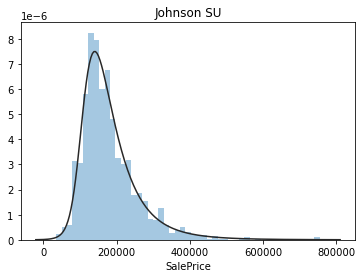

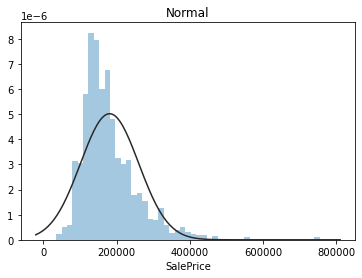

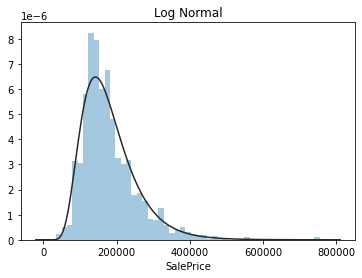

In [218]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)


In [219]:
overfit = []
for i in df_test.columns:
    counts = df_test[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df_test) * 100 > 99:
        overfit.append(i)

print(overfit)


['Street', 'Utilities', 'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


In [220]:
variables = ['Street', 'Utilities', 'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea']

for variable in variables:
    contingency_table = pd.crosstab(df_train[variable], y)
    chi2, p_val, _, _ = stats.chi2_contingency(contingency_table)
    
    print(f"Chi-square statistic for {variable}: {chi2}")
    print(f"P-value for {variable}: {p_val}")
    print("")

Chi-square statistic for Street: 888.3129945096931
P-value for Street: 8.338870380464053e-09

Chi-square statistic for Utilities: 242.49942883253368
P-value for Utilities: 1.0

Chi-square statistic for Heating: 4201.387994086523
P-value for Heating: 2.477753304101386e-24

Chi-square statistic for LowQualFinSF: 14075.959074500854
P-value for LowQualFinSF: 0.9999999999931052

Chi-square statistic for 3SsnPorch: 11019.272906377033
P-value for 3SsnPorch: 1.0

Chi-square statistic for PoolArea: 3928.982826991773
P-value for PoolArea: 0.9999999999999943



In [221]:
columns_to_drop = ['Utilities', 'LowQualFinSF', 'PoolArea','3SsnPorch']
df_train = df_train.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)


In [222]:
train_df_na_cols = set(df_train.columns.values[df_train.isnull().any()])
test_df_na_cols = set(df_test.columns.values[df_test.isnull().any()])

cols = list(set(train_df_na_cols).union(test_df_na_cols))
df_train[cols].info(verbose=False)

cat_cols = df_train[cols].select_dtypes(include='object').columns.values
num_cols = df_test[cols].select_dtypes(exclude='object').columns.values

print(f'\nNA cols remains: {len(cat_cols)} string cols and  {len(num_cols)} numeric.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 27 entries, GarageType to BsmtHalfBath
dtypes: float64(2), int64(8), object(17)
memory usage: 308.1+ KB

NA cols remains: 17 string cols and  10 numeric.


In [223]:
cat_cols


array(['GarageType', 'MSZoning', 'BsmtQual', 'BsmtCond', 'GarageQual',
       'BsmtExposure', 'BsmtFinType1', 'GarageCond', 'BsmtFinType2',
       'GarageFinish', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Electrical', 'Functional', 'KitchenQual', 'SaleType'],
      dtype=object)

In [224]:
num_cols



array(['BsmtFinSF2', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtUnfSF',
       'MasVnrArea', 'BsmtFullBath', 'GarageCars', 'GarageArea',
       'GarageYrBlt', 'BsmtHalfBath'], dtype=object)

In [225]:
skewed_feats = df_train[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
BsmtFinSF2,4.250888
BsmtHalfBath,4.099186
MasVnrArea,2.666326
BsmtFinSF1,1.683771
TotalBsmtSF,1.522688
BsmtUnfSF,0.919323
BsmtFullBath,0.595454
GarageArea,0.179796
GarageCars,-0.342197
GarageYrBlt,-0.648708


In [226]:
# 針對類別欄位 (有高頻眾數的)
train_df_mode = df_train[cat_cols].describe(exclude=[np.number])
train_df_mode = train_df_mode.loc[['top','freq'],:].transpose()
train_df_mode_dict = train_df_mode[train_df_mode.freq > 1000]['top'].to_dict()

# 針對類別欄位 (沒有高頻眾數的)
none_dict = {}
for key in train_df_mode[train_df_mode.freq <= 1000].index.values:
    none_dict[key] = 'NA'
    
# 合併高頻眾數填補值和低頻眾數填補值
train_df_mode_dict.update(none_dict)
train_df_mode_dict

{'MSZoning': 'RL',
 'BsmtCond': 'TA',
 'GarageQual': 'TA',
 'GarageCond': 'TA',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'Functional': 'Typ',
 'SaleType': 'WD',
 'GarageType': 'NA',
 'BsmtQual': 'NA',
 'BsmtExposure': 'NA',
 'BsmtFinType1': 'NA',
 'GarageFinish': 'NA',
 'Exterior1st': 'NA',
 'Exterior2nd': 'NA',
 'MasVnrType': 'NA',
 'KitchenQual': 'NA'}

In [227]:
df_train.fillna(value=train_df_mode_dict, inplace=True)


In [228]:
# This code is used to find the most common value (mode) for each categorical column in the train_df DataFrame, but only for columns where the mode occurs more than 1000 times.

test_df_mode = df_test[cat_cols].describe(exclude=[np.number])
test_df_mode = test_df_mode.loc[['top','freq'],:].transpose()
test_df_mode_dict = test_df_mode[test_df_mode.freq > 1000]['top'].to_dict()


none_dict = {}
for key in test_df_mode[test_df_mode.freq <= 1000].index.values:
    none_dict[key] = 'NA'
    
# 合併高頻眾數填補值和低頻眾數填補值
test_df_mode_dict.update(none_dict)
test_df_mode_dict

{'MSZoning': 'RL',
 'BsmtCond': 'TA',
 'GarageQual': 'TA',
 'GarageCond': 'TA',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'Functional': 'Typ',
 'SaleType': 'WD',
 'GarageType': 'NA',
 'BsmtQual': 'NA',
 'BsmtExposure': 'NA',
 'BsmtFinType1': 'NA',
 'GarageFinish': 'NA',
 'Exterior1st': 'NA',
 'Exterior2nd': 'NA',
 'MasVnrType': 'NA',
 'KitchenQual': 'NA'}

In [229]:
df_test.fillna(value=test_df_mode_dict, inplace=True)


In [230]:
df_train.GarageYrBlt.fillna(value=1980, inplace=True)
df_train[num_cols] = df_train[num_cols].fillna((df_train[num_cols].median()))

In [231]:
df_test.GarageYrBlt.fillna(value=1980, inplace=True)
df_test[num_cols] = df_test[num_cols].fillna((df_test[num_cols].median()))


In [232]:
print('Training set cols have missing values: ', sum(df_train.isnull().any()))
print('Testing set cols have missing values: ', sum(df_test.isnull().any()))


Training set cols have missing values:  0
Testing set cols have missing values:  0


## Feature Engineering 

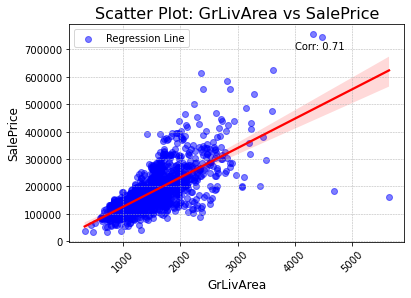

In [233]:
fig, ax = plt.subplots()
pp = sns.regplot(data=df_train, x='GrLivArea', y='SalePrice', scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Set axis labels and title
ax.set_xlabel('GrLivArea', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.set_title('Scatter Plot: GrLivArea vs SalePrice', fontsize=16)

# Add grid lines
ax.grid(True, linestyle='--', linewidth=0.5)

# Add a legend
ax.legend(['Regression Line'])

# Customize the tick labels
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# Add text annotation
corr_coeff = np.corrcoef(df_train['SalePrice'], df_train['GrLivArea'])[0, 1]
ax.text(4000, 700000, 'Corr: %.2f' % corr_coeff, fontsize=10)

# Show the plot
plt.show()


In [234]:
X = df_train.copy()
X = X.select_dtypes(include=np.number)
Y = X.pop('SalePrice')


In [235]:
X2 = sm.add_constant(X)
lm = sm.OLS(Y, X2)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     193.6
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:27:11   Log-Likelihood:                -17321.
No. Observations:                1460   AIC:                         3.471e+04
Df Residuals:                    1427   BIC:                         3.488e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           3.68e+05   1.41e+06      0.261      0.794    -2.4e+06    3.13e+06
Id               -1.2823      2.180     -0.588      0.557      -5.559       2.994
MSSubClass     -173.2518     26.285     -6.591      0.000    -224.814    -121.690
LotArea           0.4104      0.101      4.071      0.000       0.213       0.608
OverallQual    1.732e+04   1188.507     14.570      0.000     1.5e+04    1.96e+04
OverallCond    4720.9755   1032.802      4.571      0.000    2695.002    6746.949
YearBuilt       258.8101     67.167      3.853      0.000     127.054     390.566
YearRemodAdd    134.1303     68.650      1.954      0.051      -0.536     268.797
MasVnrArea       31.6290      5.932      5.332      0.000      19.993      43.265
BsmtFinSF1        9.7117      2.524      3.847      0.000       4.760      14.664
BsmtFinSF2       -1.1880      4.505     -0.264      0.792     -10.026       7.650
BsmtUnfSF         0.3089      2.408      0.128      0.898      -4.415       5.033
TotalBsmtSF       8.8326      3.363      2.626      0.009       2.236      15.429
1stFlrSF         26.1583     20.480      1.277      0.202     -14.017      66.333
2ndFlrSF         25.9464     20.140      1.288      0.198     -13.561      65.454
GrLivArea        21.7088     19.932      1.089      0.276     -17.390      60.808
BsmtFullBath   9554.6077   2611.134      3.659      0.000    4432.535    1.47e+04
BsmtHalfBath   2221.1290   4088.932      0.543      0.587   -5799.834    1.02e+04
FullBath       3890.6214   2826.714      1.376      0.169   -1654.339    9435.582
HalfBath      -1562.4778   2659.623     -0.587      0.557   -6779.668    3654.713
BedroomAbvGr  -1.032e+04   1695.863     -6.083      0.000   -1.36e+04   -6988.636
KitchenAbvGr  -1.278e+04   5204.070     -2.456      0.014    -2.3e+04   -2573.218
TotRmsAbvGrd   5148.9447   1233.967      4.173      0.000    2728.360    7569.529
Fireplaces     3903.6563   1777.187      2.197      0.028     417.477    7389.836
GarageYrBlt     133.9463     68.942      1.943      0.052      -1.292     269.185
GarageCars     1.162e+04   2872.631      4.044      0.000    5983.097    1.73e+04
GarageArea       -5.7662      9.904     -0.582      0.561     -25.195      13.663
WoodDeckSF       23.6218      7.977      2.961      0.003       7.973      39.270
OpenPorchSF      -3.6206     15.179     -0.239      0.812     -33.396      26.155
EnclosedPorch     9.8096     16.829      0.583      0.560     -23.203      42.823
ScreenPorch      55.2407     17.163      3.219      0.001      21.573      88.908
MiscVal          -0.7729      1.855     -0.417      0.677      -4.411       2.865
MoSold          -11.6264    344.410     -0.034      0.973    -687.230     663.977
YrSold         -730.5307    700.950     -1.042      0.297   -2105.533     644.472
=================================================

## Identify outlier / leverage

In [236]:
influence = result.get_influence()
student_res = influence.resid_studentized_external

In [237]:
student_res_idx = np.where(abs(student_res) > 3)[0]  # 回傳符合條件的index value

print(student_res[student_res_idx])

print('\nNumber of influencial points: {}'.format(len(student_res_idx)))

[  3.51403167   4.42055277   3.56480645 -10.67175214  -3.56717466
   3.78270838   8.15985858   3.59823553   3.04554872   6.66267245
   6.49462851   6.07910725   4.91815334   4.0450678    8.72006006
   3.5175173  -17.77211405  -3.86936982]

Number of influencial points: 18


In [238]:
df_train = df_train.drop(index=student_res_idx)
df_train.reset_index(inplace=True, drop=True)

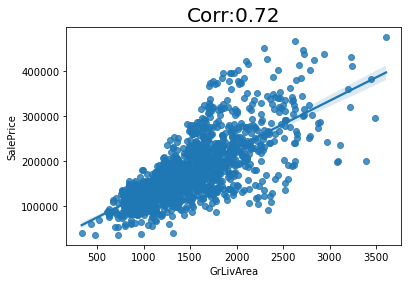

In [239]:
fig, ax = plt.subplots()
pp = sns.regplot(data=df_train, x='GrLivArea', y='SalePrice')
_ = pp.set_title('Corr:%.2f' % np.corrcoef(df_train['SalePrice'], df_train
                                           ['GrLivArea'])[0, 1], size=20)

## Target variable transformation

In [240]:
print('The skewness of target variable: {:.3f}'.format(df_train.SalePrice.skew()))
print('If skewness greater than 0.5, needed to be transformed.')


The skewness of target variable: 1.150
If skewness greater than 0.5, needed to be transformed.


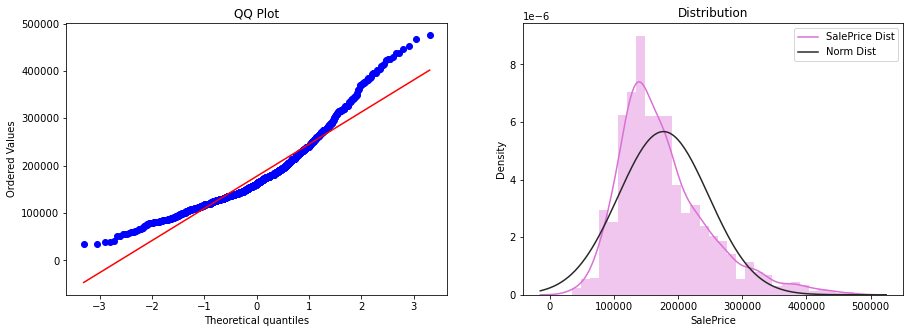

In [241]:
from scipy import stats
from scipy.stats import norm

arr = df_train.SalePrice.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_ = stats.probplot(arr, plot=ax[0])
_ = sns.distplot(arr,
                 color="orchid",
                 kde=True,
                 fit=norm,
                 ax=ax[1],
                 axlabel='SalePrice',
                 kde_kws={"label": "SalePrice Dist"},
                 fit_kws={"label": "Norm Dist"})

ax[1].legend(loc='best')
_ = ax[0].set_title('QQ Plot')
_ = ax[1].set_title('Distribution')


In [242]:
y_orig = df_train.SalePrice
y = np.log1p(df_train.SalePrice)

print('The skewness of transformed target variable: {:.3f}'.format(y.skew()))


The skewness of transformed target variable: -0.070


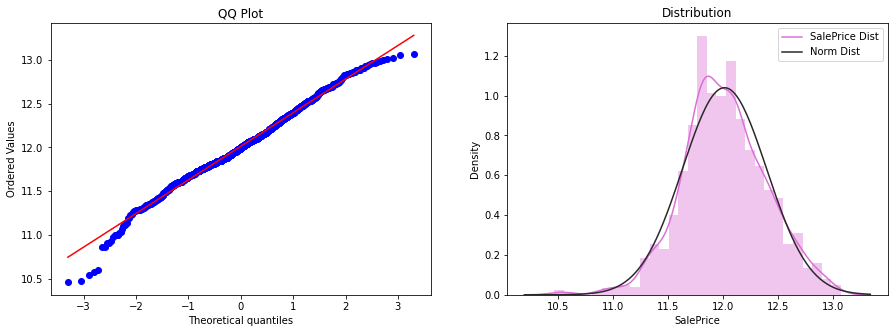

In [243]:


arr = y.copy()

# 繪製QQ plot and distribution plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_ = stats.probplot(arr, plot=ax[0])
_ = sns.distplot(arr,
                 color="orchid",
                 kde=True,
                 fit=norm,
                 ax=ax[1],
                 axlabel='SalePrice',
                 kde_kws={"label": "SalePrice Dist"},
                 fit_kws={"label": "Norm Dist"})

ax[1].legend(loc='best')
_ = ax[0].set_title('QQ Plot')
_ = ax[1].set_title('Distribution')


## Identify feature that has lower than 0.1 coeff

In [244]:
train_df_corr = df_train.select_dtypes(include='integer').corr()['SalePrice']
values = train_df_corr[abs(train_df_corr) < 0.1].index.values
values


array(['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'BsmtHalfBath',
       'MiscVal', 'MoSold', 'YrSold'], dtype=object)

In [245]:
num2cat = []
for val in values:
    if len(df_train[val].unique()) < 20:
        num2cat.append(val)

num2cat


['MSSubClass', 'OverallCond', 'BsmtHalfBath', 'MoSold', 'YrSold']

In [246]:

numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,24.300687
LotArea,12.829976
KitchenAbvGr,4.452036
BsmtFinSF2,4.248503
ScreenPorch,4.170898
BsmtHalfBath,4.134035
EnclosedPorch,3.062227
MasVnrArea,2.594512
OpenPorchSF,2.353545
WoodDeckSF,1.560438


In [247]:

numeric_feats = df_test.dtypes[df_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,24.300687
LotArea,12.829976
KitchenAbvGr,4.452036
BsmtFinSF2,4.248503
ScreenPorch,4.170898
BsmtHalfBath,4.134035
EnclosedPorch,3.062227
MasVnrArea,2.594512
OpenPorchSF,2.353545
WoodDeckSF,1.560438


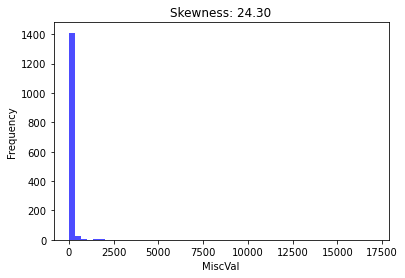

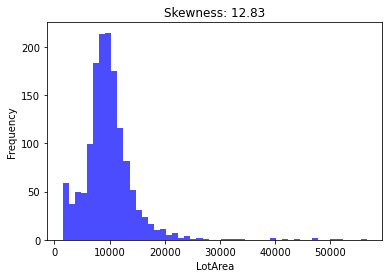

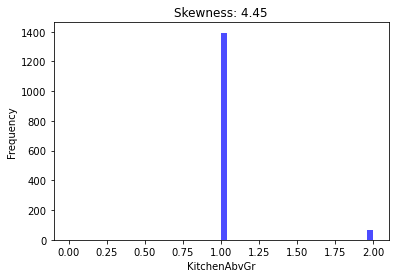

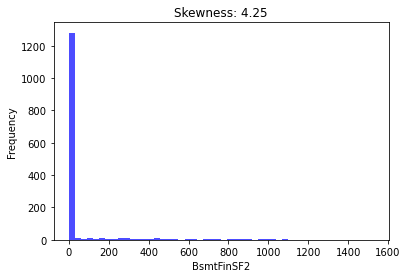

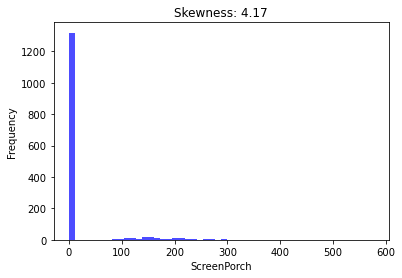

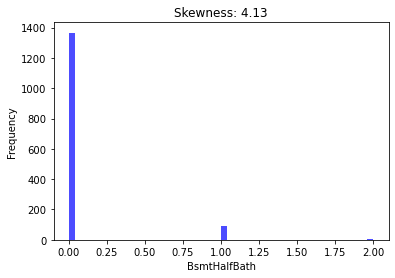

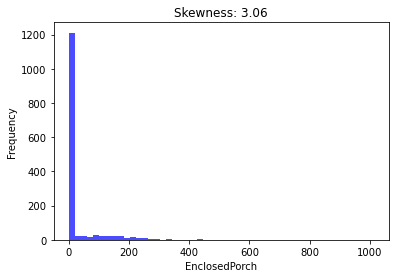

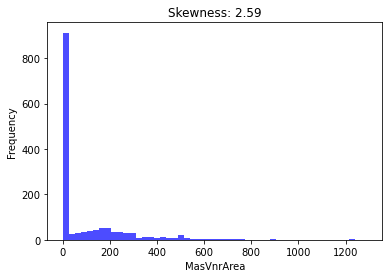

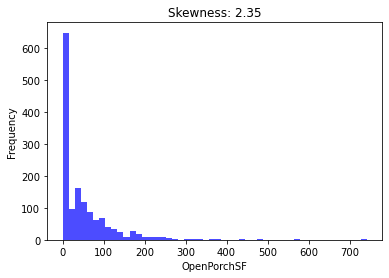

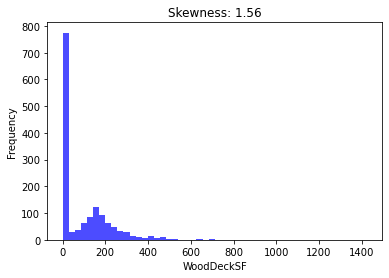

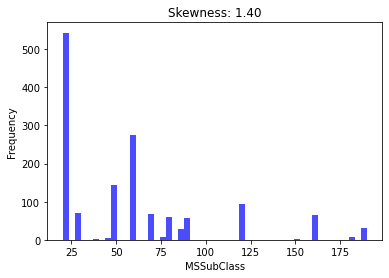

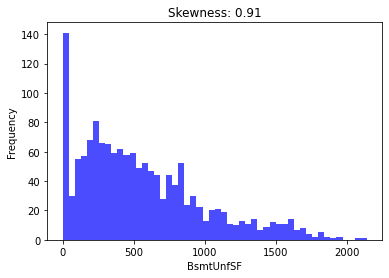

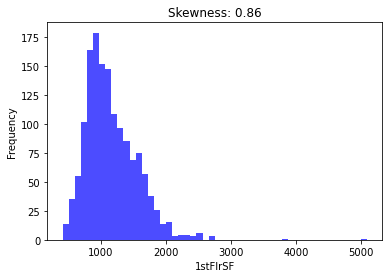

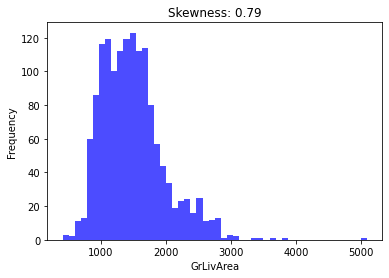

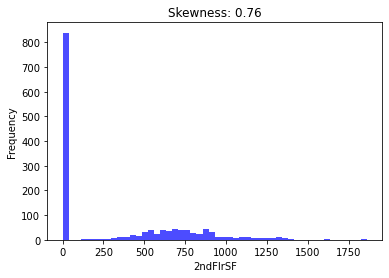

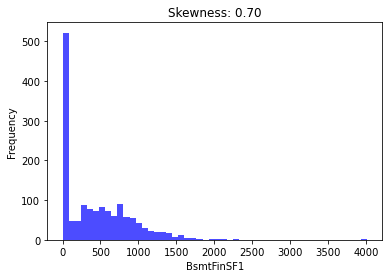

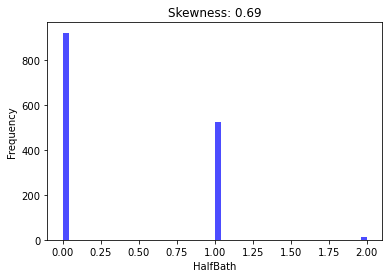

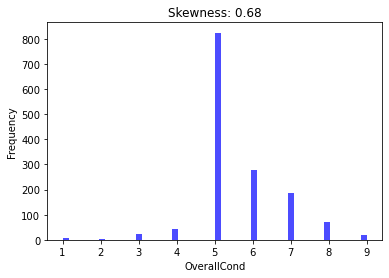

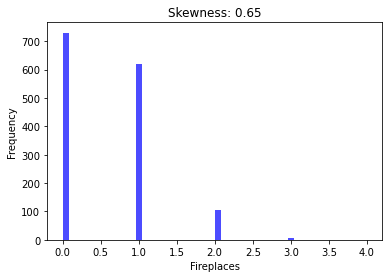

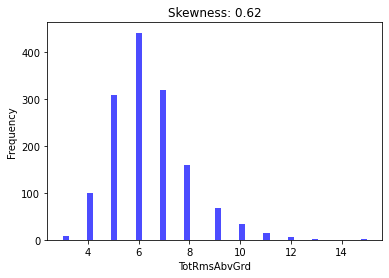

In [248]:
top_skewness = skewness.head(20)

# Create individual plots for the top 20 skewed features
for feature in top_skewness.index:
    plt.figure(figsize=(6, 4))
    plt.hist(df_test[feature].dropna(), bins=50, color='blue', alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Skewness: {skewness.loc[feature, "Skew"]:.2f}')
    plt.show()


In [249]:
X = df_train.copy()
X.pop('SalePrice')
X = pd.get_dummies(X)
print("Number of unfiltered columns: ", X.shape)

rf = RandomForestRegressor(
     random_state=20,
     n_estimators=500,
     min_samples_leaf=0.01)

rf.fit(X, y)

Number of unfiltered columns:  (1442, 270)


RandomForestRegressor(min_samples_leaf=0.01, n_estimators=500, random_state=20)

In [250]:
from scipy.stats import boxcox

In [251]:
ft_ip = pd.Series(
    data = rf.feature_importances_,
    index = X.columns,
    name = 'feature_importance')

ft_ip = ft_ip.sort_values(ascending=False)
cum_sum = ft_ip.cumsum()
cum_sum.name = 'ft_ip_cumsum'
ft_ip = pd.concat([ft_ip, cum_sum], axis=1)


In [252]:
cols_idx = ft_ip[ft_ip['ft_ip_cumsum'] < 0.9999].index

ft_ip.loc[cols_idx,:]


,feature_importance,ft_ip_cumsum
OverallQual,0.619999,0.619999
GrLivArea,0.122704,0.742703
TotalBsmtSF,0.048417,0.791120
GarageCars,0.040822,0.831941
GarageArea,0.031567,0.863508
...,...,...
RoofStyle_Gable,0.000021,0.999839
Functional_Typ,0.000017,0.999856
BsmtFinType1_Rec,0.000013,0.999870
SaleType_WD,0.000013,0.999883


In [253]:

print('Length of cols(inflated by dummy variables): {}'.format(len(cols_idx)))
cols = [i.split('_')[0] for i in cols_idx.values]
cols = list(set(cols))
print('Lenght of unique cols: {}'.format(len(cols)))


Length of cols(inflated by dummy variables): 82
Lenght of unique cols: 54


In [254]:
num_cols = df_train[cols].select_dtypes(include=np.number).columns.values
cat_cols = df_train[cols].select_dtypes(include='object').columns.values


In [255]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', MinMaxScaler(), num_cols)],
    verbose=True)


In [256]:
X = preprocessor.fit_transform(df_train[cols])


[ColumnTransformer] ........... (1 of 2) Processing cat, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.0s


In [257]:
X_test = preprocessor.transform(df_test[cols])


## Model

In [258]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle = True)


In [259]:
def rmse(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    RMSE_train = np.sqrt(mean_squared_error(y_train, pred_train))
    RMSE_val = np.sqrt(mean_squared_error(y_val, pred_val))
    return RMSE_train, RMSE_val


#  provide a convenient way to calculate the R-squared scores for different models


In [260]:
from xgboost import XGBRegressor

models = [ElasticNet(), KNeighborsRegressor(), SVR(), 
          AdaBoostRegressor(), RandomForestRegressor(), 
          XGBRegressor(objective ='reg:squarederror'),
         KernelRidge()]

names = ['Elastic', 'KNN', 'SVR', 'ADA', 'RF', 'XGB']
for name, model in zip(names, models):
    RMSE_train, RMSE_val = rmse(model, X_train, X_val, y_train, y_val)
    print(f'{name}:')
    print(f'　　Training RMSE: {RMSE_train:.4f}, Validation RMSE: {RMSE_val:.4f}')


Elastic:
　　Training RMSE: 0.3770, Validation RMSE: 0.4039
KNN:
　　Training RMSE: 0.1559, Validation RMSE: 0.1969
SVR:
　　Training RMSE: 0.0759, Validation RMSE: 0.1424
ADA:
　　Training RMSE: 0.1346, Validation RMSE: 0.1757
RF:
　　Training RMSE: 0.0492, Validation RMSE: 0.1576
XGB:
　　Training RMSE: 0.0059, Validation RMSE: 0.1504


## Model Tuning, Cross Validation

In [261]:
def fitGridModel(model, params, train_x, train_y):
    '''define a function to implement GridSearch all in one'''
    reg_model = clone(model)
    best_params = {}

    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    grid = RandomizedSearchCV(reg_model,
                              param_distributions=params,
                              scoring=scorer,
                              cv=5,
                              n_iter=10,
                              n_jobs=-1,
                              random_state=2022,
                              verbose=1)
    grid.fit(train_x, train_y)
    score = np.sqrt(abs(grid.best_score_))  # root of mse
    print(
        "the best rmse of all model parameters' combination on model: {:.4f}".format(score))
    best_params.update(grid.best_params_)
    print("the parameter setting of optimized model:", grid.best_estimator_)

    return score, best_params, grid


## XGboost

In [262]:
from sklearn.base import clone


In [263]:
xgb_score, xgb_params, xgb_grid_model = fitGridModel(xgb.XGBRegressor(),
                                                     params={
                                                         'objective': ['reg:squarederror'],
                                                         'learning_rate': beta(a=2, b=20, loc=0, scale=0.01),
                                                         'n_estimators': randint(low=2500, high=3500),
                                                         'gamma': beta(a=2,b=20, loc=0, scale=0.01),
                                                         'colsample_bytree': uniform(loc=0.6, scale=1.0),
                                                         'subsample': uniform(loc=0.6, scale=1.0),
                                                         'max_depth': [2, 7],
                                                         'min_child_weight': [0, 1, 2],
                                                         'seed': [27],
                                                         'scale_pos_weight': [1],
                                                         'reg_alpha': beta(a=2, b=20, loc=0, scale=0.01)
                                                     },
                                                     train_x=X,
                                                     train_y=y)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
the best rmse of all model parameters' combination on model: 3.0344
the parameter setting of optimized model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9395094745874908, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0009117111283150373, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.00041219573609133553, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=3253, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [264]:
train_predictions = xgb_grid_model.predict(X)
train_r2 = r2_score(y, train_predictions)
print("R-squared of the training dataset:", train_r2)

# Predict on the validation set
val_predictions = xgb_grid_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
print("R-squared of the validation dataset:", val_r2)


R-squared of the training dataset: -61.40555673396563
R-squared of the validation dataset: -55.053066158733955


In [265]:
xgb_grid_model.fit(X, y)
train_predictions = np.expm1(xgb_grid_model.predict(X_test))
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': train_predictions})
submit_file.to_csv('./submission.csv', index=False)


Fitting 5 folds for each of 10 candidates, totalling 50 fits



## KNN

In [97]:
from sklearn.neighbors import KNeighborsRegressor

knn_score, knn_params, knn_grid_model = fitGridModel(KNeighborsRegressor(),
                                                     params={
                                                         'n_neighbors': randint(low=20, high=40),
                                                         'weights': ['uniform', 'distance'],
                                                         'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                         'leaf_size': randint(low=1, high=30),
                                                         'p': [1, 2]
                                                     },
                                                     train_x=X,
                                                     train_y=y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_b

/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/wutingkang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_b

the best rmse of all model parameters' combination on model: 0.1919
the parameter setting of optimized model: KNeighborsRegressor(algorithm='brute', leaf_size=9, n_neighbors=31, p=1,
                    weights='distance')


In [98]:
train_predictions = knn_grid_model.predict(X)
train_r2 = r2_score(y, train_predictions)
print("R-squared of the training dataset:", train_r2)

# Predict on the validation set
val_predictions = knn_grid_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
print("R-squared of the validation dataset:", val_r2)

R-squared of the training dataset: 1.0
R-squared of the validation dataset: 1.0


In [99]:
KNN_y = np.expm1(knn_grid_model.predict(X_test))

submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': KNN_y})
submit_file.to_csv('./submission.csv', index=False)


## Random Forest

In [100]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

rf_score, rf_params, rf_grid_model = fitGridModel(RandomForestRegressor(),
                                                 params={
                                                     'n_estimators': randint(low=1500, high=2500),
                                                     'max_depth': randint(low=10, high=15),
                                                     'min_samples_split': randint(low=2, high=12),
                                                     'min_samples_leaf': randint(low=1, high=12),
                                                     'max_features': ['auto', 'sqrt'],
                                                     'bootstrap': [True],
                                                     'random_state': [27]
                                                 },
                                                 train_x=X,
                                                 train_y=y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
the best rmse of all model parameters' combination on model: 0.1327
the parameter setting of optimized model: RandomForestRegressor(max_depth=11, min_samples_split=6, n_estimators=2310,
                      random_state=27)


In [101]:
train_predictions = rf_grid_model.predict(X)
train_r2 = r2_score(y, train_predictions)
print("R-squared of the training dataset:", train_r2)

# Predict on the validation set
val_predictions = rf_grid_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
print("R-squared of the validation dataset:", val_r2)


R-squared of the training dataset: 0.9744094047145403
R-squared of the validation dataset: 0.9744073915769622


In [102]:
rf_grid_model.fit(X, y)
train_predictions = np.expm1(rf_grid_model.predict(X_test))
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': train_predictions})
submit_file.to_csv('./submission.csv', index=False)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


## SVM

In [445]:
# SVR
svr_score, svr_params, svr_grid_model = fitGridModel(
    model=SVR(),
    params={
        'C': randint(low=30, high=50),
        'gamma': beta(a=2, b=10, loc=0, scale=0.1),
        'epsilon': beta(a=2, b=10, loc=0, scale=0.05)
    },
    train_x=X, 
    train_y=y)
    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
the best rmse of all model parameters' combination on model: 0.1223
the parameter setting of optimized model: SVR(C=40, epsilon=0.0015775696585159016, gamma=0.006349407974466631)


In [448]:
train_predictions = svr_grid_model.predict(X)
train_r2 = r2_score(y, train_predictions)
print("R-squared of the training dataset:", train_r2)

# Predict on the validation set
val_predictions = svr_grid_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
print("R-squared of the validation dataset:", val_r2)

R-squared of the training dataset: 0.9900114281735098
R-squared of the validation dataset: 0.9953536778242078


In [449]:
svr_grid_model.fit(X, y)
SVR_train_predictions = np.expm1(svr_grid_model.predict(X_test))
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': SVR_train_predictions})
submit_file.to_csv('./submission.csv', index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## ADABOOST

In [486]:

from sklearn.tree import DecisionTreeRegressor

ada_score, ada_params, ada_grid_model = fitGridModel(AdaBoostRegressor(),
                                                    params={
                                                        'base_estimator': [DecisionTreeRegressor(max_depth=8), DecisionTreeRegressor(max_depth=8)],
                                                        'n_estimators': randint(low=1500, high=2500),
                                                        'learning_rate': uniform(loc=0.01, scale=1.0),
                                                        'loss': ['linear', 'square', 'exponential'],
                                                        'random_state': [27]
                                                    },
                                                    train_x=X,
                                                    train_y=y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
the best rmse of all model parameters' combination on model: 0.1325
the parameter setting of optimized model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  learning_rate=0.08902435137076091, loss='square',
                  n_estimators=2301, random_state=27)


In [487]:
train_predictions = ada_grid_model.predict(X)
train_r2 = r2_score(y, train_predictions)
print("R-squared of the training dataset:", train_r2)

# Predict on the validation set
val_predictions = ada_grid_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
print("R-squared of the validation dataset:", val_r2)

R-squared of the training dataset: 0.9891457915647943
R-squared of the validation dataset: 0.9901552705727327


In [488]:

voting_pred_y = np.expm1(ada_grid_model.predict(X_test))


submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice':voting_pred_y})
submit_file.to_csv('./submission.csv', index=False)

## Blending

In [496]:
import pprint

params = {
    AdaBoostRegressor: ada_params,
    RandomForestRegressor:rf_params,
    KNeighborsRegressor:knn_params

}

weights = [0.4,0.3,0.3]
pprint.pprint(params)


{<class 'sklearn.neighbors._regression.KNeighborsRegressor'>: {'algorithm': 'brute',
                                                               'leaf_size': 9,
                                                               'n_neighbors': 31,
                                                               'p': 1,
                                                               'weights': 'distance'},
 <class 'sklearn.ensemble._forest.RandomForestRegressor'>: {'bootstrap': True,
                                                            'max_depth': 11,
                                                            'max_features': 'auto',
                                                            'min_samples_leaf': 1,
                                                            'min_samples_split': 6,
                                                            'n_estimators': 2310,
                                                            'random_state': 27},
 <class 'sklearn.ensemble.

In [497]:
x = X
true_y = y.values

models = [rf_grid_model,ada_grid_model,knn_grid_model]

blend_y = np.sum([weight * reg.predict(x) for weight, reg in zip(weights, models)], axis=0)
rmse = np.sqrt(abs(mean_squared_error(true_y, blend_y)))
print("RMSE of train dataset: ", rmse)
r2 = r2_score(true_y, blend_y)
print("R-squared of train dataset: ", r2)

RMSE of train dataset:  0.033633834152861454
R-squared of train dataset:  0.9923234350214287


In [498]:
blend_y_val = np.sum([weight * reg.predict(X_test) for weight, reg in zip(weights, models)], axis=0)
blend_y_val = np.expm1(blend_y_val)  # Apply exponential transformation to individual predictions

submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': blend_y_val})
submit_file.to_csv('./submission.csv', index=False)

In [ ]:
xgb_grid_model.fit(X, y)
train_predictions = np.expm1(xgb_grid_model.predict(X_test))
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': train_predictions})
submit_file.to_csv('./submission.csv', index=False)


In [1567]:
models.fit(X,y)
blend_y1 = np.sum([1/len(models)*np.expm1(reg.predict(X_test)) for reg in models], axis=0)
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice': blend_y1})
submit_file.to_csv('./submit_blend_y.csv', index=False)


## Voting Regressor

In [ ]:
# Train the models and obtain the best estimators
knn_grid_model.fit(X, y)
xgb_grid_model.fit(X, y)
ada_grid_model.fit(X,y)
# Define the list of estimators
models = [
    ('ADA', ada_grid_model.ada_params),
    ('XGB', xgb_grid_model.xbg_params),
    ('SVR', svr_grid_model.svr_params)
]

voting_regressor = VotingRegressor(estimators=models)

# Fit the Voting Regressor on the training data
voting_regressor.fit(X, y)

# Predict on the training data
blend_y = voting_regressor.predict(X)

# Calculate the RMSE and R-squared on the training data
rmse_train = np.sqrt(mean_squared_error(y, blend_y))
r2_train = r2_score(y, blend_y)

# Print the results
print("RMSE of the training dataset:", rmse_train)
print("R-squared of the training dataset:", r2_train)



In [502]:
voting_pred_y = np.expm1(voting_regressor.predict(X_test))
submit_file = pd.DataFrame({'Id': df_test.Id, 'SalePrice':voting_pred_y})
submit_file.to_csv('./submission.csv', index=False)
